In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import regression as rg
import seaborn as sns

In [192]:
class PoissonRegressionGPT:
    def __init__(
        self,
        alpha: float = 1e-2,          # initial learning rate
        decay: float = 1e-4,          # learning-rate decay per update
        batch_size: int = 32,         # mini-batch size
        max_epochs: int = 100,        # passes through the data
        tol: float = 1e-6,            # early-stopping threshold
        clip_norm: float = 5.0,       # gradient‐norm clipping
        standardize: bool = True      # feature‐scaling toggle
    ):
        self.alpha = alpha
        self.decay = decay
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.tol = tol
        self.clip_norm = clip_norm
        self.standardize = standardize
        self.theta = None
        self.mean_ = None
        self.std_ = None

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _scale(self, X):
        if self.standardize:
            self.mean_ = X.mean(axis=0)
            self.std_ = X.std(axis=0, ddof=1)
            # avoid division by zero
            self.std_[self.std_ == 0] = 1.0
            return (X - self.mean_) / self.std_
        else:
            return X

    def fit(self, X, y):
        # 1) Optionally standardize features (exclude intercept)
        X = self._scale(X)

        # 2) Add intercept column
        Xb = self._add_intercept(X)
        n, p = Xb.shape

        # 3) Initialize parameters
        theta = np.zeros(p, dtype=float)

        # 4) Run mini-batch SGD with decay & clipping
        update_count = 0
        for epoch in range(self.max_epochs):
            # shuffle indices each epoch
            perm = np.random.permutation(n)
            for start in range(0, n, self.batch_size):
                idx = perm[start:start + self.batch_size]
                X_batch = Xb[idx]
                y_batch = y[idx]

                # predictions and gradient
                eta = X_batch.dot(theta)                 # shape (batch_size,)
                lam = np.exp(eta)                       # λ = exp(η)
                # gradient of log-likelihood over the batch:
                # ∇ = Xᵀ (y − λ)
                grad = X_batch.T.dot(y_batch - lam) / len(idx)

                # clip gradient norm
                norm = np.linalg.norm(grad)
                if norm > self.clip_norm:
                    grad *= (self.clip_norm / norm)

                # learning‐rate with decay
                lr = self.alpha / (1 + self.decay * update_count)

                update = lr * grad
                theta_new = theta + update

                # early stopping
                if np.linalg.norm(update) < self.tol:
                    self.theta = theta_new
                    return self

                theta = theta_new
                update_count += 1

        self.theta = theta
        return self

    def predict_rate(self, X):
        # apply same scaling
        if self.standardize:
            X = (X - self.mean_) / self.std_
        Xb = self._add_intercept(X)
        return np.exp(Xb.dot(self.theta))

In [193]:
model = PoissonRegressionGPT()

In [194]:
ds4_train, ds4_valid = pd.read_csv("data/ds4_train.csv"), pd.read_csv("data/ds4_valid.csv")
ds4_train.head()

,x_1,x_2,x_3,x_4,y
0,1.0,0.0,0.992047,0.325741,2463097
1,0.0,1.0,0.470463,0.371866,645481
2,0.0,1.0,0.496533,0.289853,474123
3,0.0,1.0,0.196377,0.694672,1542136
4,0.0,1.0,0.224992,0.880809,3705439


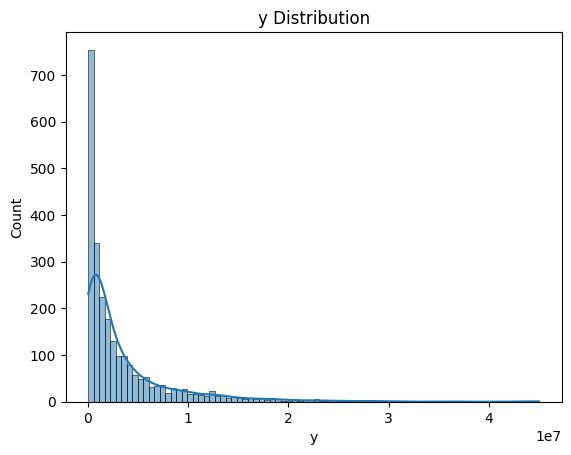

In [195]:
sns.histplot(ds4_train, x='y', kde=True)
plt.title('y Distribution')
plt.show()

Looks poisson like! If it were a - hmmm never mind - we'll skip the data visualisation part and defer it for later for closer inspection

In [196]:
x1,x2,x3,x4,y = np.array([ds4_train[col] for col in ds4_train.columns])
features_matrix = np.column_stack([x1,x2,x3,x4])

In [197]:
model.fit(features_matrix, y)

In [198]:
theta = model.theta

In [199]:
predictions = model.predict_rate(features_matrix)

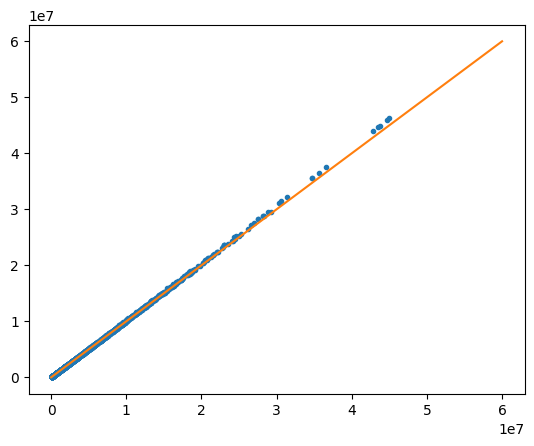

In [200]:
plt.plot(y, predictions,'.')
x=np.linspace(0,6e7, 100)
plt.plot(x,x)
plt.show()

In [294]:
class PoissonRegression:
    def standardise(self, X: np.ndarray) -> np.ndarray:
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0, ddof=1)
        return (X - self.mean) / self.std
    def add_intercept(self, X: np.ndarray) -> np.ndarray:
        return np.column_stack([np.ones(len(X)), X])
    def h(self, X: np.ndarray, theta: np.ndarray) -> np.ndarray:
        Xb = self.add_intercept(X)
        return np.exp(np.dot(Xb, theta))
    def update_theta(self, X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float) -> np.ndarray:
        Xb = self.add_intercept(X)
        return theta + alpha * np.dot(Xb.T, y - self.h(X, theta))/len(X)
    def gradient_ascent(self, X: np.ndarray, y: np.ndarray, theta_0: np.ndarray, alpha: float, tol: float) -> np.ndarray:
        theta = theta_0
        X_scaled = self.standardise(X)
        for i in range(100000):
            theta_new = self.update_theta(X_scaled,y,theta,alpha)
            if np.linalg.norm(theta_new-theta,1) < tol:
                break
            theta = theta_new
        self.theta = theta
        return theta
model2 = PoissonRegression()

In [301]:
model2.gradient_ascent(features_matrix, y, [0,0,0,0,0], alpha=1e-7, tol=0.01)

array([14.09009289,  0.1143774 , -0.1143774 ,  0.59773977,  1.3500382 ])

In [302]:
predictions = model2.h(model2.standardise(features_matrix), model2.theta)

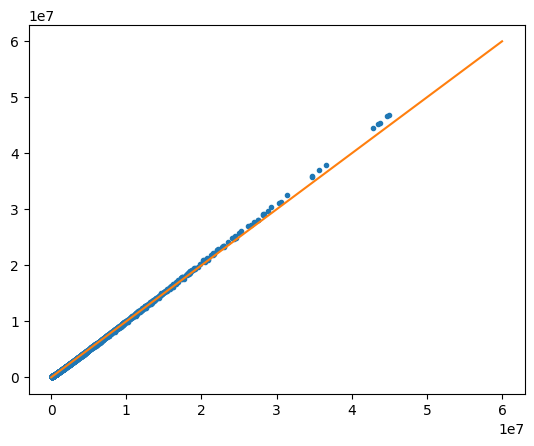

In [303]:
plt.plot(y, predictions,'.')
x=np.linspace(0,6e7, 100)
plt.plot(x,x)
plt.show()

it's very clear that standardising is the best way for helping w convergence

Usually it is not necessary that since the fit to the training set is good that the fit to the test set will also be good - but we've applied a GLM (i.e. minimal assumptions/constraints) and we're not necessarily overfitting anways. We're also lucky since the question was designed around poisson regression so we can already assume that the assumptions we worked with will work just as well with the valid set.